In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from astropy.io import fits 

from astropy.modeling.models import BlackBody
import astropy.units as u
from glob import glob

from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import astropy.table as at
import sys 
sys.path.append('../../../source_synphot/')
import source_synphot.passband as passband
import source_synphot.io as io
import source_synphot.source
from tools import *

from make_synmags import Spec_mags

from copy import deepcopy
def my_norm(Spec,pbs,mag):
    spec = deepcopy(Spec)
    #m = Syn_mag(pbs,spec)
    syn_mag = source_synphot.passband.synphot(spec,pbs[0],zp=pbs[1])
    m = syn_mag
    factor = 10**(-2/5*(mag-m))
    print(factor)
    spec = S.ArraySpectrum(wave=spec.wave,waveunits=spec.waveunits,
                                   flux=spec.flux*factor,fluxunits=spec.fluxunits)
    return spec

def Specs(Specs):
    specs = {}
    for spec in Specs:
        model_sed = source_synphot.source.pre_process_source(spec,np.nan,'ps1g',0,Renorm=False)
        specs[spec] = model_sed

    return specs

In [140]:
passbands = at.Table.read('../../../source_synphot/source_synphot/passbands/pbzptmag.txt',format='ascii')

model_mags = 0.
model = 'AB'
ftess = [x['obsmode'] for x in passbands if x['passband'].startswith("TESS")]
ftess = ftess[0]
ftess = source_synphot.passband.load_pbs(ftess, model_mags, model)
pbnames = ftess.keys()

pb_swope = source_synphot.passband.load_pbs(['CSP2.g','CSP2.r'], model_mags, model,SVO=True)
pb_ztf = source_synphot.passband.load_pbs(['ZTF.g','ZTF.r'], model_mags, model,SVO=True)
pb_atlas = source_synphot.passband.load_pbs(['Atlas.orange'], model_mags, model,SVO=True)

SVO
SVO
SVO
SVO
SVO


In [141]:
spec_info = np.loadtxt('./spec/fqv_spec_times.txt',dtype=object)
spec_files = ['./spec/'+x for x in spec_info[:,0]]
spec_times = spec_info[:,1].astype(float)

In [142]:
s = Specs(spec_files)

Warning, 3 of 1429 bins contained negative fluxes; they have been set to zero.
Warning, 2 of 1442 bins contained negative fluxes; they have been set to zero.


<IPython.core.display.Javascript object>


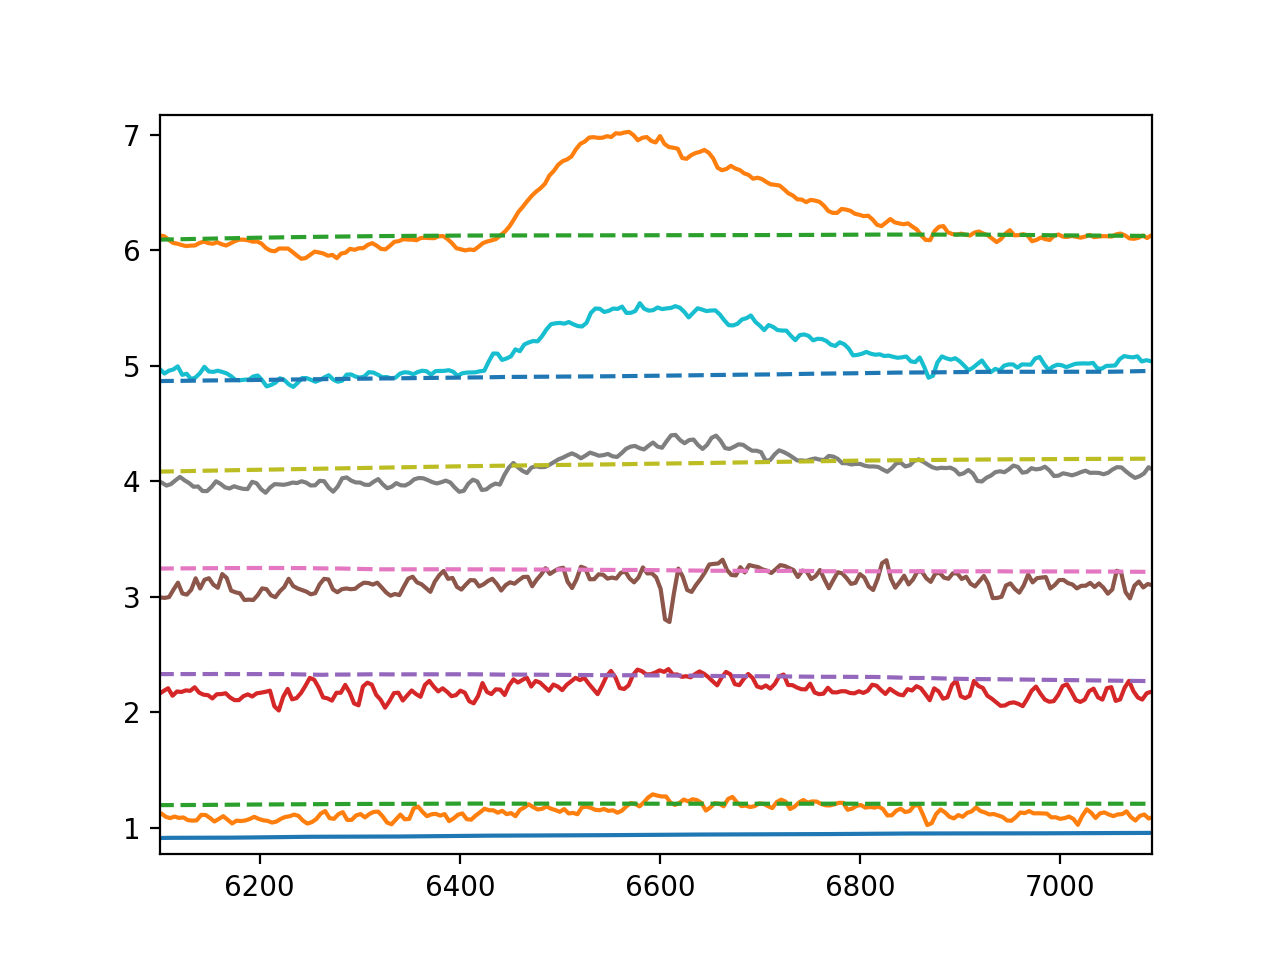

In [143]:
x = np.arange(3371.79,11500,4.42)
keys = list(s.keys())
plt.figure()
plt.plot(ftess['tess'][0].wave,ftess['tess'][0].throughput)
plt.plot(pb_atlas['Atlas.orange'][0].wave,pb_atlas['Atlas.orange'][0].throughput,'C1')
i = 0
for key in keys:
    smooth = savgol_filter(s[key].flux,5,3)
    plt.plot(s[key].wave,smooth/np.nanmedian(smooth)+i)
    f = savgol_filter(s[key].flux,1001,3)
    extr = interp1d(s[key].wave,f,bounds_error=False,fill_value='extrapolate')
    extr = extr(x)
    plt.plot(x,extr/np.nanmedian(extr)+i,'--')
    i+=1

In [41]:
se = OrderedDict()
for key in keys:
    smooth = savgol_filter(s[key].flux,21,3)
    f = savgol_filter(s[key].flux,1001,3)
    extr = interp1d(s[key].wave,f,bounds_error=False,fill_value='extrapolate')
    extr = extr(x)
    ind = x > s[key].wave.data[-1]
    tmp = deepcopy(s[key].wave.data)
    extended_wave = np.append(tmp,x[ind])
    extended_flux = np.append(smooth,extr[ind])
    
    se[key] = S.ArraySpectrum(extended_wave,extended_flux)

<IPython.core.display.Javascript object>


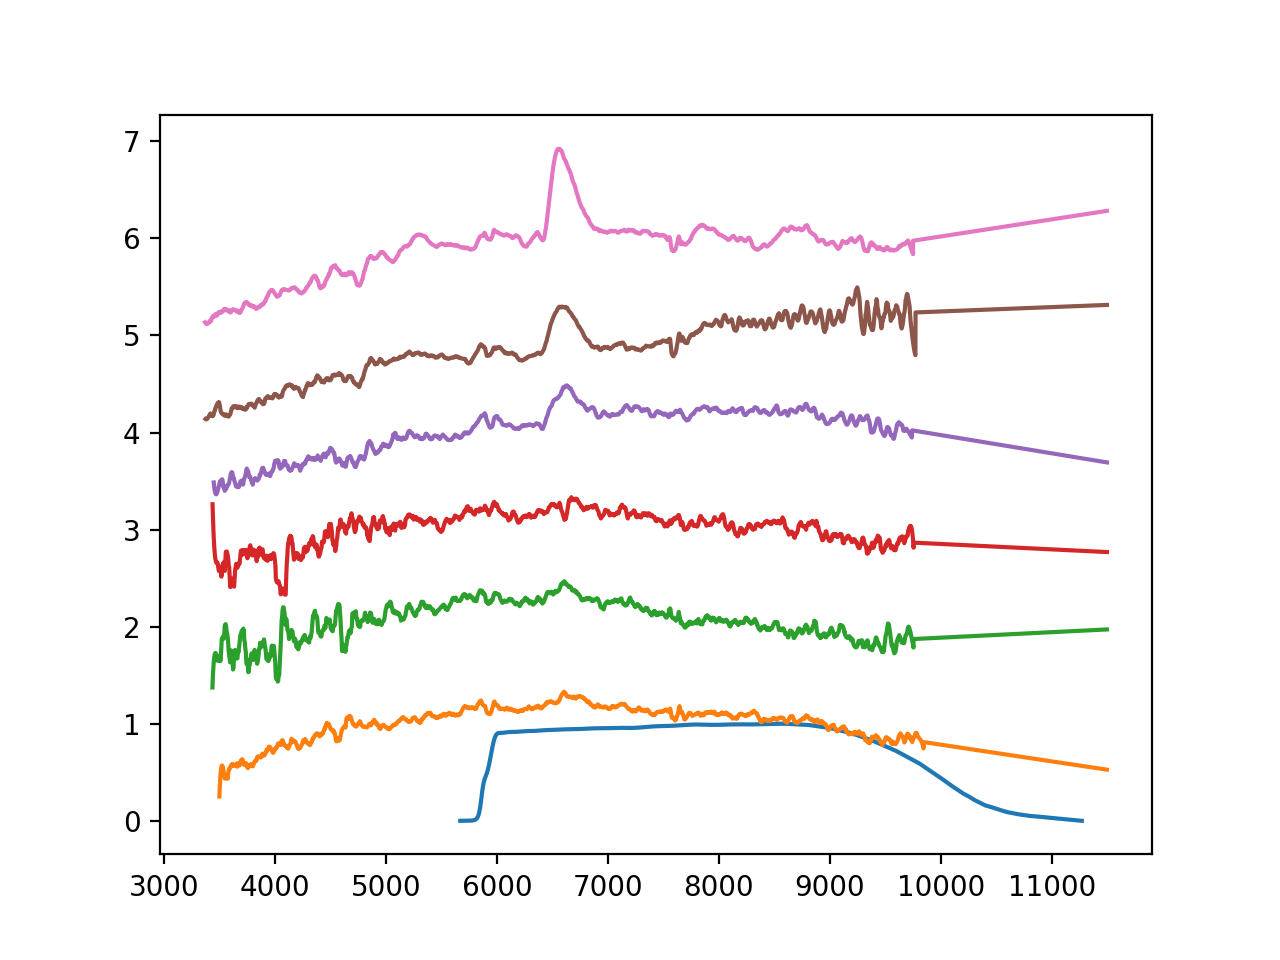

In [42]:
plt.figure()
plt.plot(ftess['tess'][0].wave,ftess['tess'][0].throughput)
i = 0
for key in keys:
    smooth = se[key].flux
    plt.plot(se[key].wave,smooth/np.nanmedian(smooth)+i)
    i +=1

In [43]:
import sys
sys.path.append('../../')
from TESS_ATLAS_Swope import *
import pandas as pd

In [44]:
c,o = Atlas_lcs('fqv_atlas.txt')
cc = Atlas_day(c)
oo = Atlas_day(o)

In [11]:
s[key].wave.data[0]

3371.79

In [45]:
ind1 = 0
ind2 = 2
ind3 = 3

In [46]:
spec_times[ind2]

58943.2750284

In [47]:
at_1 = np.argmin(abs(oo[:,0] - spec_times[ind1]))
at_2 = np.argmin(abs(oo[:,0] - spec_times[ind2]))
at_3 = np.argmin(abs(oo[:,0] - spec_times[ind3]))

In [48]:
(abs(oo[:,0] - spec_times[ind2])).min()

0.1795442250004271

In [49]:
spec1 = my_norm(se[keys[ind1]],pb_atlas['Atlas.orange'],oo[at_1,1])
spec2 = my_norm(se[keys[ind2]],pb_atlas['Atlas.orange'],oo[at_2,1])
spec3 = my_norm(se[keys[ind3]],pb_atlas['Atlas.orange'],oo[at_3,1])

1.4309363050203294
2.9235667703782457
2.9179718295888026


In [51]:
speco = [spec1,spec2,spec3]
synt = Spec_mags(speco,ftess)

In [52]:
tess = np.load('20fqv_strip_bkg.npy')
tess2 = np.loadtxt('diff_lc.txt')
tess[1] -= np.nanmedian(tess[1,380:500])
tess2[1] -= np.nanmedian(tess2[1,380:500])

<IPython.core.display.Javascript object>


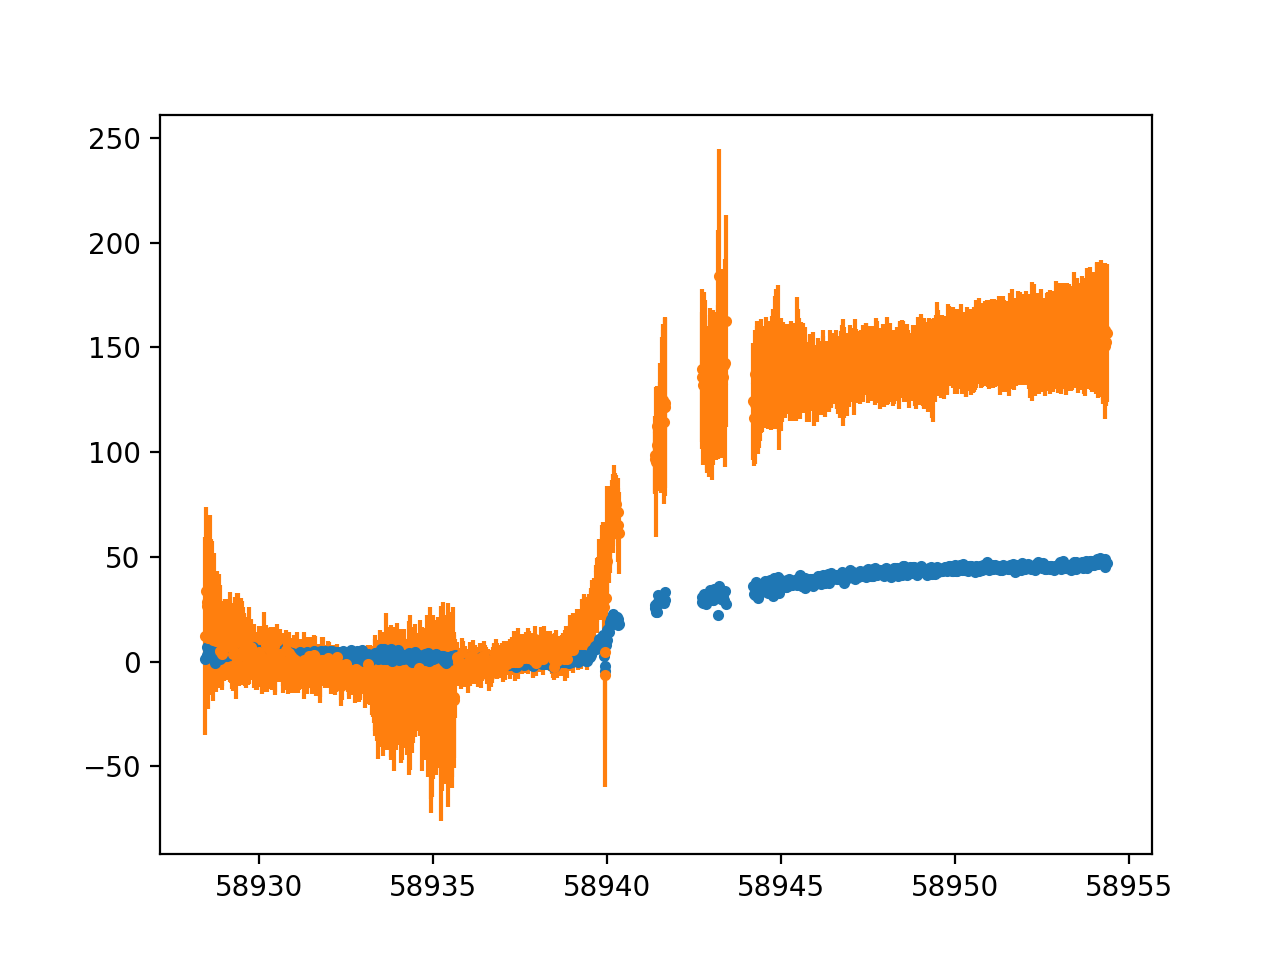

<ErrorbarContainer object of 3 artists>

In [53]:
plt.figure()
plt.plot(tess[0],tess[1],'.')
plt.errorbar(tess2[0],tess2[1],yerr=tess2[2],fmt='.')

In [21]:
eh = tess2[:,np.isfinite(tess2[1])]

In [22]:
np.where(np.diff(eh[0]) > 0.5)

(array([570, 586, 618]),)

In [26]:
eh[0,618]

58943.412170410156

In [54]:
import tessreduce as tr

In [57]:
c,t = tr.bin_data(tess2[1],tess2[0],12)

<IPython.core.display.Javascript object>


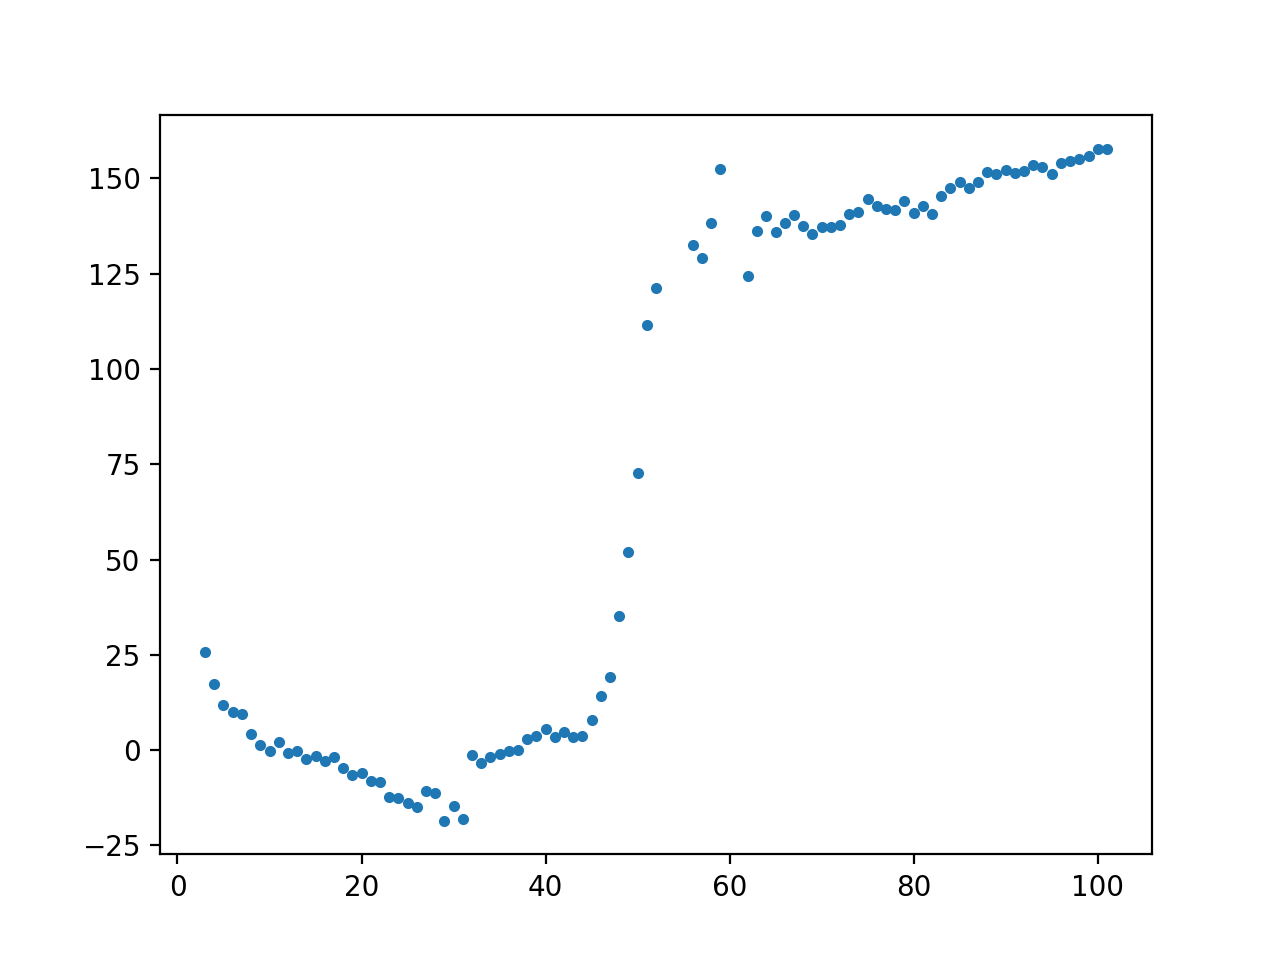

In [58]:
plt.figure()
plt.plot(c,'.')

<IPython.core.display.Javascript object>


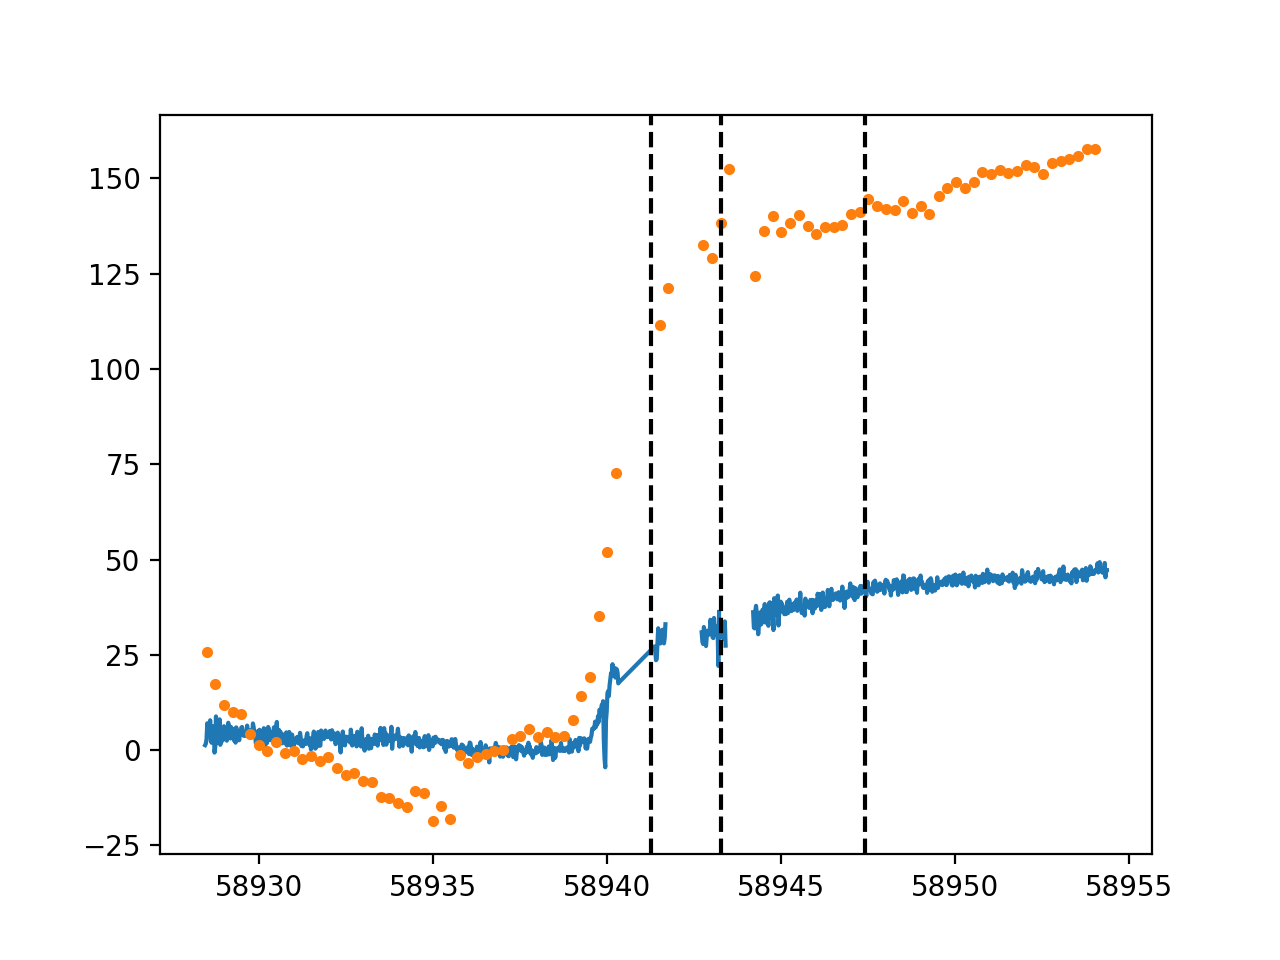

In [59]:
plt.figure()
plt.plot(tess[0],tess[1])
plt.plot(t,c,'.')
plt.axvline(spec_times[ind1],color='k',ls='--')
plt.axvline(spec_times[ind2],color='k',ls='--')
plt.axvline(spec_times[ind3],color='k',ls='--')

In [60]:
t_1 = np.argmin(abs(t - spec_times[ind1]))
t_2 = np.argmin(abs(t - spec_times[ind2]))
t_3 = np.argmin(abs(t - spec_times[ind3]))

In [61]:
m1 = -2.5*np.log10(c[t_1])
m2 = -2.5*np.log10(c[t_2])
m3 = -2.5*np.log10(c[t_3])
ms = np.array([m1,m2,m3])

In [62]:
ms

array([-5.11971451, -5.35286256, -5.39954681])

In [63]:
diff = synt['tess'] - ms

In [64]:
zp = np.nanmedian(diff[:2])

In [65]:
ezp = np.nanstd(diff[:2])

<IPython.core.display.Javascript object>


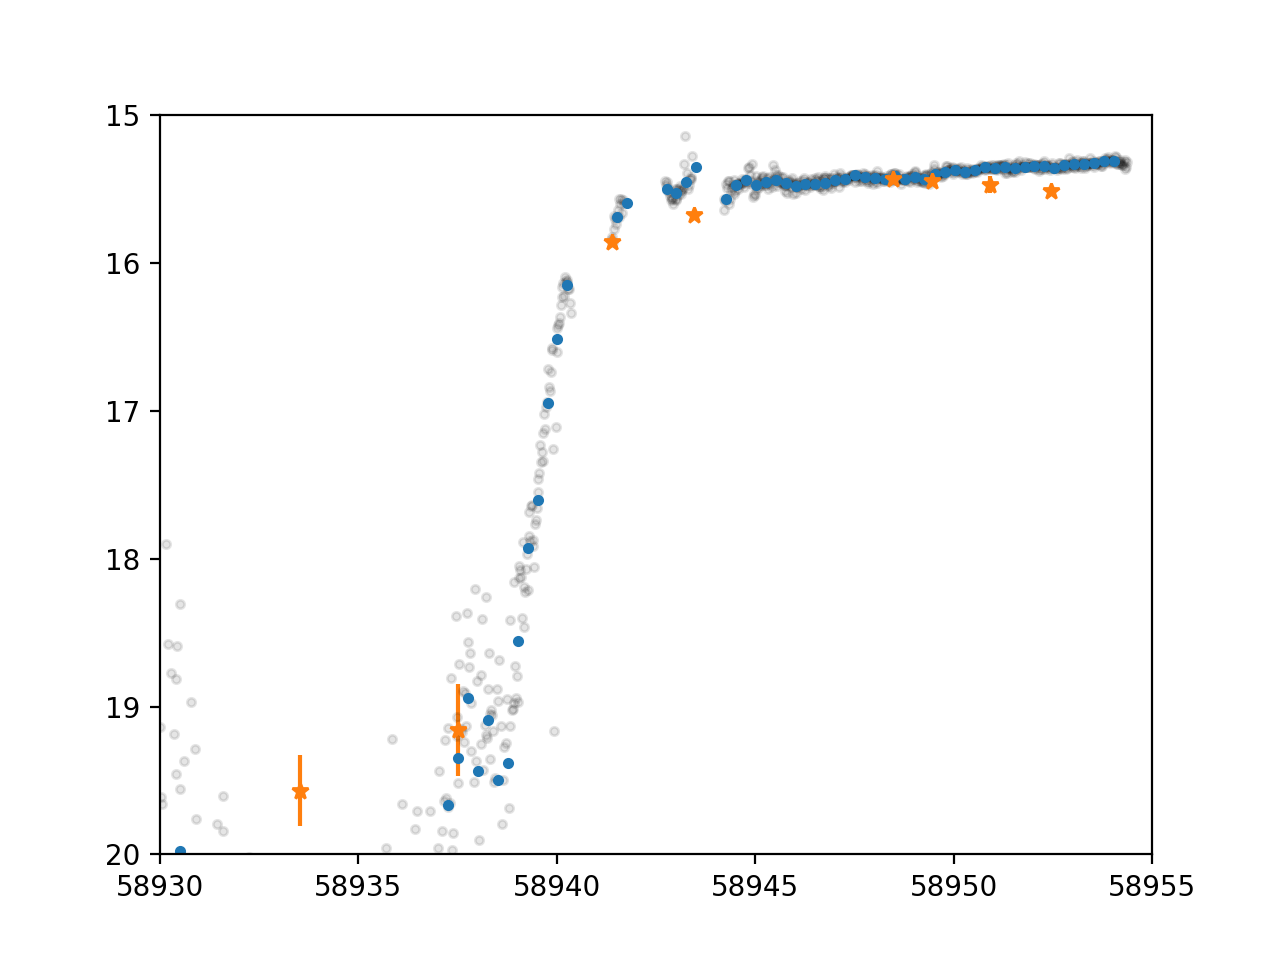

(58930.0, 58955.0)

In [66]:
plt.figure()
plt.plot(tess2[0],-2.5*np.log10(tess2[1])+zp,'k.',alpha=.1)
plt.plot(t,-2.5*np.log10(c)+zp,'.')
plt.errorbar(oo[:,0],oo[:,1],oo[:,2],fmt='*')
plt.gca().invert_yaxis()
plt.ylim(20,15)
plt.xlim(58930,58955)


In [67]:
zp

20.806194922907096

In [68]:
ezp

0.02374814451440166

In [69]:
diff

array([20.78244678, 20.82994307, 20.54730899])

In [61]:
np.savetxt('20fqv_difflc.txt',tess.T)

<IPython.core.display.Javascript object>


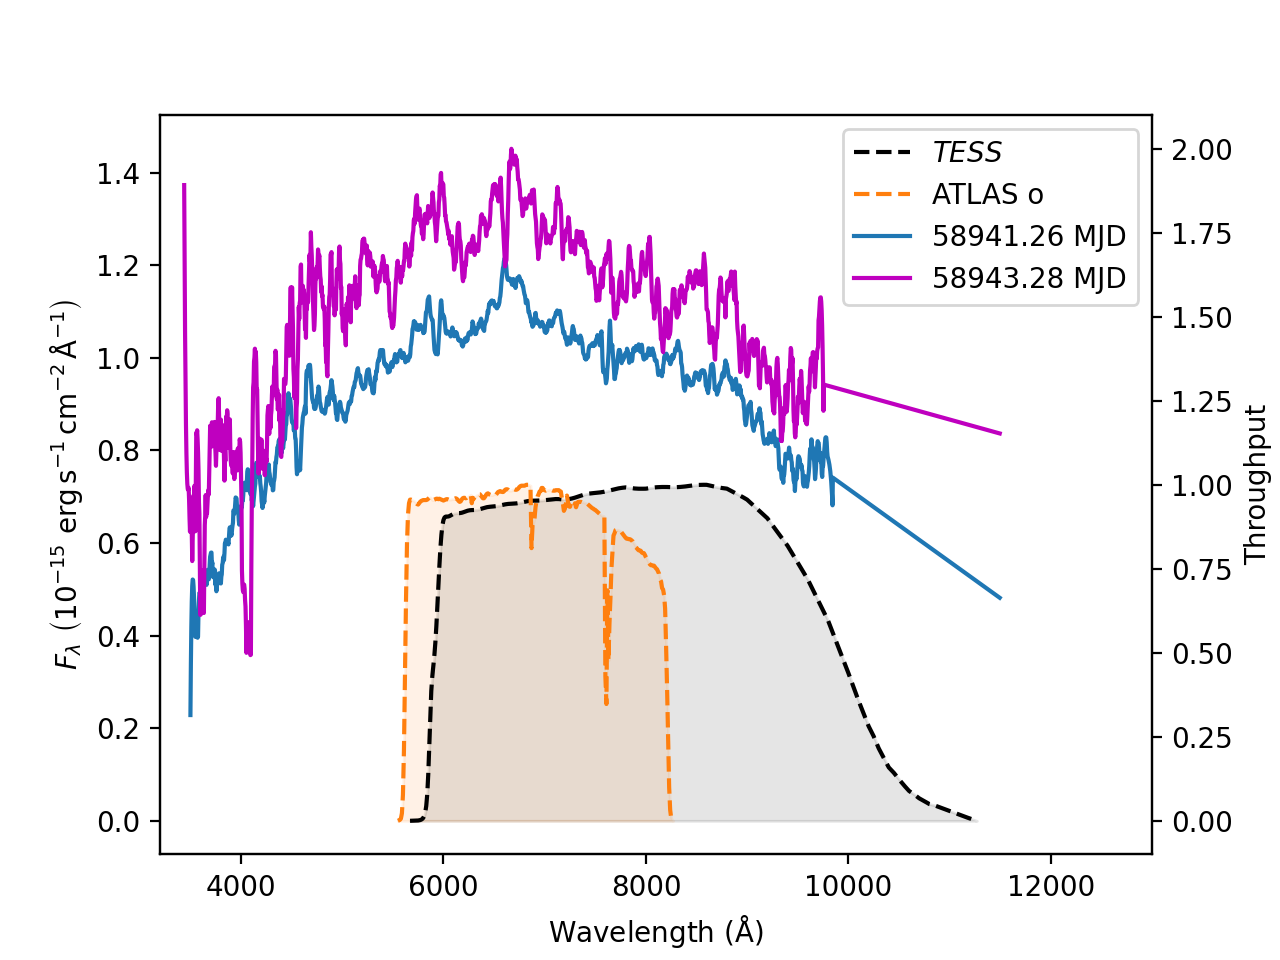

In [134]:

aw = pb_atlas['Atlas.orange'][0].wave
at = pb_atlas['Atlas.orange'][0].throughput/np.nanmax(pb_atlas['Atlas.orange'][0].throughput)
scale = np.nanmax(spec2.flux/1e-15)/2
fig, ax =plt.subplots()


plt.fill_between(ftess['tess'][0].wave,ftess['tess'][0].throughput*scale,alpha=0.1,color='k')
plt.plot(ftess['tess'][0].wave,ftess['tess'][0].throughput*scale,'k--',label=r'$TESS$')

plt.fill_between(aw,at*scale,alpha=0.1,color='C1')
plt.plot(aw,at*scale,'C1--',label='ATLAS o')

plt.plot(spec1.wave,spec1.flux/1e-15,label='58941.26 MJD')
plt.plot(spec2.wave,spec2.flux/1e-15,'m',label='58943.28 MJD')
plt.ylabel(r'$F_{\lambda}~\left(10^{-15}\rm~erg\,s^{-1}\,cm^{-2}\,\AA^{-1} \right)$')
plt.xlabel(r'Wavelength $\rm\left(\AA\right)$')

plt.xlim(3200,13000)
plt.legend(loc=1)
ax2 = ax.twinx()
plt.plot(ftess['tess'][0].wave,ftess['tess'][0].throughput*2,'r',label='TESS',alpha=0)

plt.ylabel('Throughput')

plt.savefig('TESS_flux_cal.pdf')

In [107]:
ax.get_zorder()

0

In [162]:
from extinction import fm07, fitzpatrick99, apply, remove

In [165]:
av = 0.52*3.22
Rv = 3.22 
apply(fitzpatrick99(wave,av,Rv),bbf.value)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.99026539e-05, 3.99020628e-05, 3.99014709e-05])

In [216]:
dered = S.ArraySpectrum(spec1.wave,remove(fitzpatrick99(spec1.wave,av,Rv),spec1.flux))
dered2 = S.ArraySpectrum(spec2.wave,remove(fitzpatrick99(spec2.wave,av,Rv),spec2.flux))

<IPython.core.display.Javascript object>


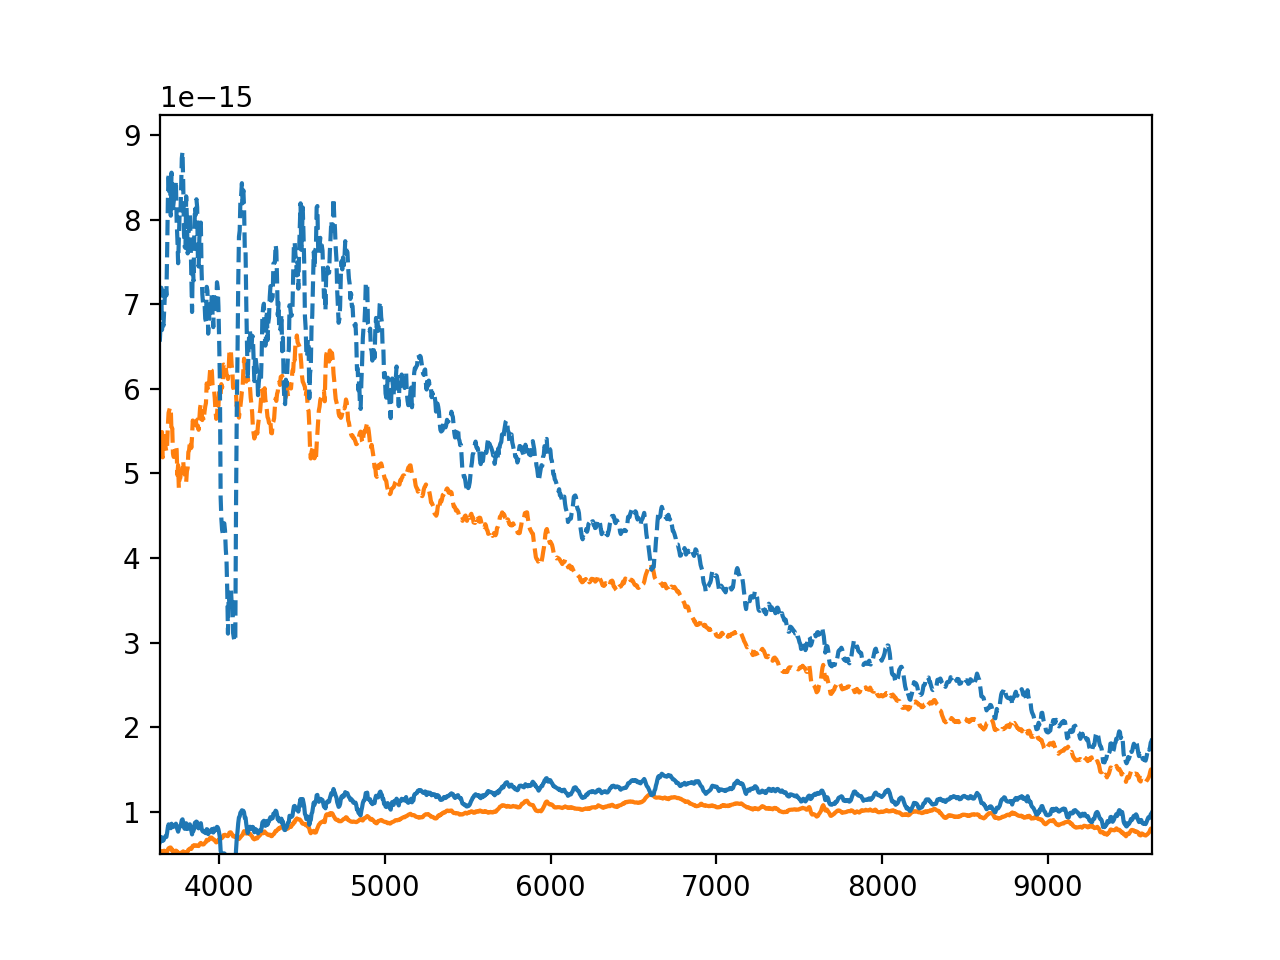

In [218]:
plt.figure()
plt.plot(spec1.wave,spec1.flux,'C1-')
plt.plot(dered.wave,dered.flux,'C1--')

plt.plot(spec2.wave,spec2.flux,'C0-')
plt.plot(dered2.wave,dered2.flux,'C0--')

In [220]:
speco = [spec1,spec2]
synt = Spec_mags(speco,ftess)

speco = [dered,dered2]
synt_r = Spec_mags(speco,ftess)

In [224]:
diff = synt['tess'] - synt_r['tess']

In [226]:
np.nanmean(diff)

1.0003636487281362

In [227]:
np.std(diff)

0.0006941601316121648

<IPython.core.display.Javascript object>


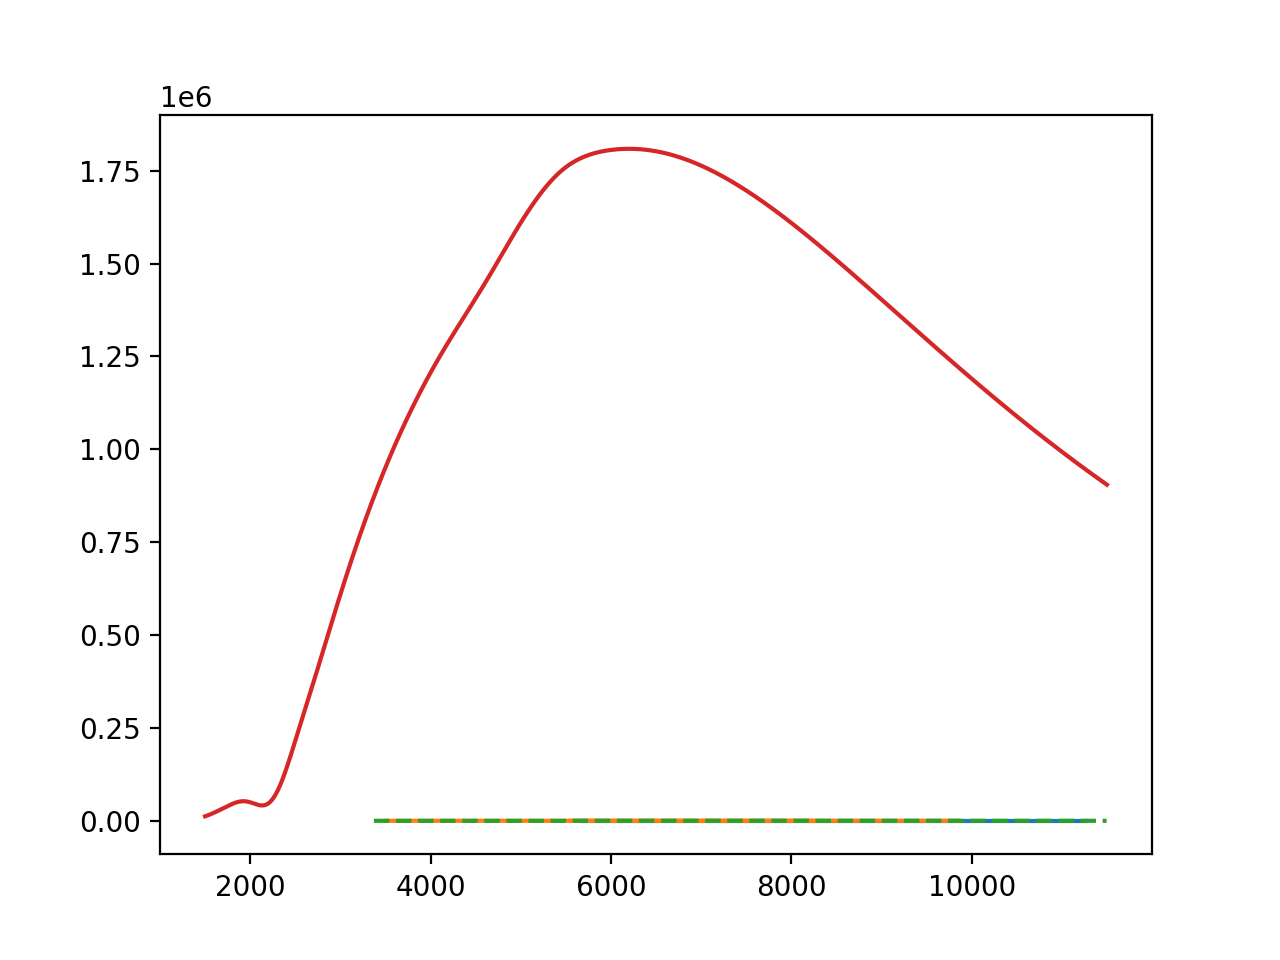

In [211]:
x = np.arange(3371.79,11500,4.42)
keys = list(s.keys())
plt.figure()
plt.plot(ftess['tess'][0].wave,ftess['tess'][0].throughput)
plt.plot(pb_atlas['Atlas.orange'][0].wave,pb_atlas['Atlas.orange'][0].throughput,'C1')
i = 0
key = keys[0]
wave = np.arange(1500,11500) * u.AA
temp = 7637 * u.K
bb = BlackBody(temp)
bbf = bb(wave).value
bbf = S.ArraySpectrum(wave=wave.value,flux=bbf,fluxunits='fnu')
#bbf = S.ArraySpectrum(wave=bbf.wave,flux=apply(fitzpatrick99(bbf.wave,av,Rv),bbf.flux))
bbf.convert('flam')

bbf = S.ArraySpectrum(wave=bbf.wave,flux=apply(fitzpatrick99(bbf.wave,av,Rv),bbf.flux))
smooth = savgol_filter(s[key].flux,5,3)
plt.plot(s[key].wave,smooth/np.nanmedian(smooth)+i)
f = savgol_filter(s[key].flux,1001,3)
extr = interp1d(s[key].wave,f,bounds_error=False,fill_value='extrapolate')
extr = extr(x)
plt.plot(x,extr/np.nanmedian(extr)+i,'--')
plt.plot(bbf.wave,bbf.flux)
i+=1

<IPython.core.display.Javascript object>


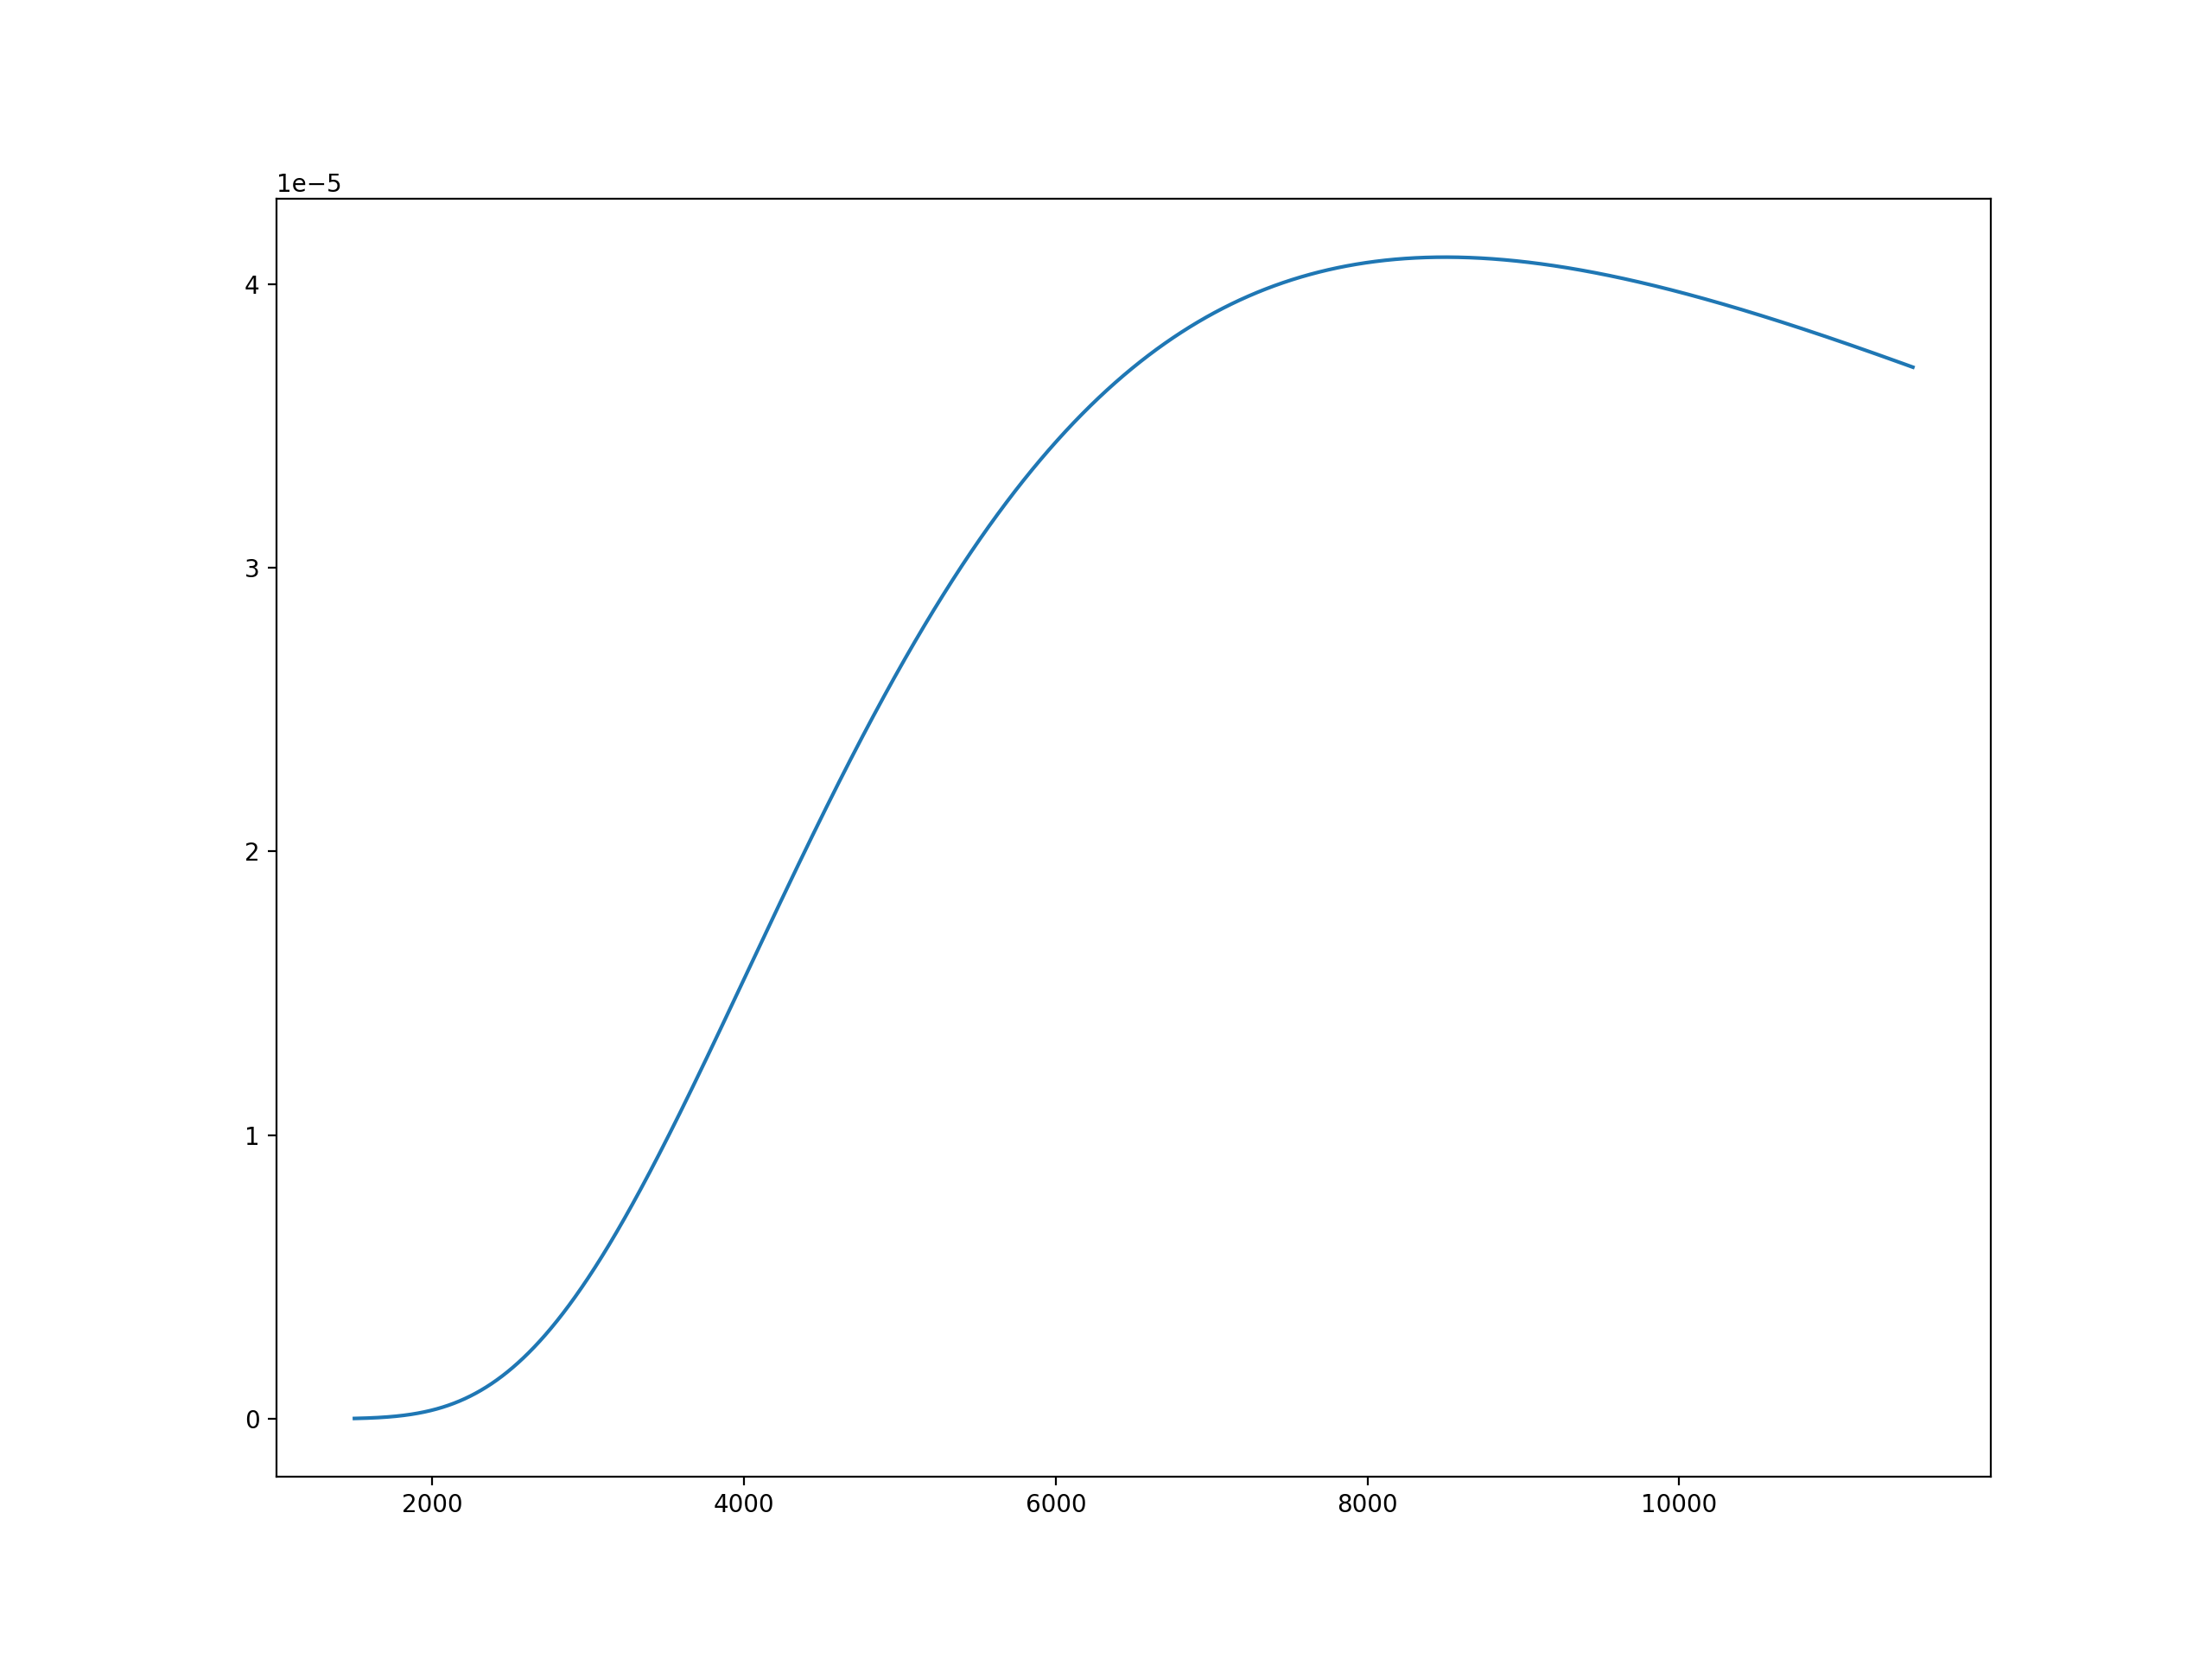

In [200]:
temp = 6000 * u.K
bb = BlackBody(temperature=temp)
bbf = bb(wave).value #* np.pi * 4 * u.sr
wave = np.arange(1500,11500) * u.angstrom
plt.figure()
plt.plot(wave,bbf)

In [201]:
wave

<Quantity [ 1500.,  1501.,  1502., ..., 11497., 11498., 11499.] Angstrom>

In [202]:
temp

<Quantity 6000. K>

In [ ]:
apply()